In [1]:
pip install adjustText


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
####################################################################################
# this code defines function to create edges for specific drainage basin
# edgesは2都市間のupstreamとdownstreamの関係をすべて保存したリスト
####################################################################################

import numpy as np
import json
from collections import defaultdict, deque

##########################################################
# kinshana river basin
# hydrabad=citynum(40)
# 19 cities
riv_num = 64
uid_str = '64.0'
distance = 100
##########################################################

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
basin_cities_path = f'{h08dir}/global_city/dat/riv_num_/basin_to_cities_{distance}km.json'

with open(basin_cities_path, 'r') as json_file:
    new_basin_to_cities = json.load(json_file)
    
def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

def nxtl2nxtxy(rgnfile, upperindex, leftindex):
    vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
    riv_nxtxy = np.empty(rgnfile.shape, dtype=tuple)
    mask = ~np.isnan(rgnfile)
    riv_nxtxy[mask] = vfunc(rgnfile[mask])
    riv_nxtxy_shape = (riv_nxtxy.shape[0], riv_nxtxy.shape[1], 2)
    
    riv_nxtxy_lst = []
    for row in riv_nxtxy:
        for y, x in row:
            modified_y = y - upperindex
            modified_x = x - leftindex
            riv_nxtxy_lst.append((modified_y, modified_x))

    riv_nxtxy_cropped = np.array(riv_nxtxy_lst).reshape(riv_nxtxy_shape)
    riv_nxtxy_cropped = riv_nxtxy_cropped.astype(int)
    return riv_nxtxy_cropped

def is_valid_edge(city1, city2, coords_dict):
    """
    multiple city at 1 coord
    then remove smaller number city at upstream (False)
    """
    for coord, city_list in coords_dict.items():
        if len(city_list) > 1:
            if city1 in city_list and city2 in city_list:
                if city1 > city2:
                    continue
                else:
                    city1, city2 = None, None
                    
    if city1 and city2:
        return True
    else:
        return False
        
def prf_int_flag(prf, intake, riv_num, rivnum_gl5, rivout_gl5):
    # unique coord
    pprf_coord = np.where((prf == 1) & (rivnum_gl5 == riv_num))
    sprf_coord = np.where((prf == 1) & (rivnum_gl5 != riv_num))
    int_coord = np.where((intake == 1) & (rivnum_gl5 == riv_num))
    
    # Create copies of prf and intake to avoid modifying original inputs
    prf_copy = np.copy(prf)
    pprf_copy = np.copy(prf)
    sprf_copy = np.copy(prf)
    intake_copy = np.copy(intake)
    
    # delete
    pprf_copy[sprf_coord] = 0
    sprf_copy[pprf_coord] = 0

    if pprf_coord[0].size != 0 and int_coord[0].size != 0:
        pprf_runout = rivout_gl5[pprf_coord][0] * 60 * 60 * 24 * 365 / 1000
        int_runout = rivout_gl5[int_coord][0] * 60 * 60 * 24 * 365 / 1000
        
        if pprf_runout > int_runout:
            print('PRF > intake')
            largest = pprf_copy
            all_int = prf_copy
            flag = 'prf-larger'
        else:
            print('INTAKE > prf')
            largest = intake_copy
            all_int = sprf_copy + intake_copy
            flag = 'intake-larger'
            
    elif pprf_coord[0].size != 0 and int_coord[0].size == 0:
        print('PRF only')
        largest = pprf_copy
        all_int = prf_copy + intake_copy
        flag = 'prf-only'
        
    elif pprf_coord[0].size == 0 and int_coord[0].size != 0:
        print('INTAKE only')
        largest = intake_copy
        all_int = prf_copy + intake_copy
        flag = 'intake-only'
        
    else:
        largest = prf_copy
        all_int = prf_copy
        print('Error: no prf no int')
        flag = 'no-prf-int'

    return flag, largest, all_int, prf_copy

def updown(new_basin_to_cities, uid_str='3.0', distance=100, riv_num=3):
    # get cities in basin
    city_list = new_basin_to_cities[uid_str]
    city_list = [int(i) for i in city_list]
    print(f'city_list: {city_list}')
    
    # remove overlap
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    overlap_path = f'{h08dir}/global_city/dat/cty_lst_/gpw4/overlap_hidden_only.txt'
    with open(overlap_path, 'r') as f:
        numbers = [int(line.strip()) for line in f]
    city_list_removed = [num for num in city_list if num not in numbers]
    city_list_removed = [int(i) for i in city_list_removed]
    print(f'city_list_removed: {city_list_removed}')
    
    # rivnextlonlat 
    rivnxl_path = f"{h08dir}/global_city/dat/riv_nxl_/rivnxl.CAMA.gl5"
    rivnxl_gl5 = np.fromfile(rivnxl_path, 'float32').reshape(2160, 4320)
    riv_nxlonlat_cropped = nxtl2nxtxy(rivnxl_gl5, 0, 0)
    
    # rivout
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout_gl5 = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    
    # coord of purificication
    coords_a = []
    for city_num in city_list_removed:
        # rivnum
        rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
        rivnum_gl5 = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320)

        # prf
        prf_dir = f'{h08dir}/global_city/dat/cty_prf_'
        prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
        prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)

        # int
        int_dir = f'{h08dir}/global_city/dat/cty_int_/{distance}km_samebasin'
        int_path = f'{int_dir}/city_{city_num:08}.gl5'
        intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
        
        # 1. prfとintどちらもが対象領域内(uid_int)でprfが大きい
        # 2. prfとintどちらもが対象領域内(uid_int)でintが大きい
        # 3. prfのみが対象流域内(uid_int)
        # 4. intのみが対象流域内(uid_int)
        uid_int = int(riv_num)
        flag, largest, all_int, prf_copy = prf_int_flag(prf, intake, uid_int, rivnum_gl5, rivout_gl5)
        largest_coord = np.where(largest==1)
        print(f'largest_coord{largest_coord}, city_num: {city_num}, uid_int: {uid_int}')
        coords_a.append([largest_coord, city_num])
        
    ####################################################################################
    # 同流域内で取水点がかぶっている都市を取水点ごとにリストにする
    ####################################################################################

    # 同じ座標に対して city_num のリストを作成するための辞書
    same_coords_dict = defaultdict(list)

    # coords_a の要素をループして座標をキーに city_num をリストに追加
    for coord, city_num in coords_a:
        for i in range(len(coord[0])):
            coord_tuple = (coord[0][i], coord[1][i])
            same_coords_dict[coord_tuple].append(city_num)
            
    ####################################################################################
        
    # down
    edges = []
    riv_path_array = np.zeros((2160, 4320))
    
    # city_num loop 
    for idx in range(len(coords_a)):

        # init
        visited_coords = set()
        
        # upstream
        cityup = coords_a[idx][1]
        
        # coords_a[idx][0] = (array([732]), array([3086]))
        riv_path_array[coords_a[idx][0][0][0], coords_a[idx][0][1][0]] = idx

        # coordinates of prf and intake
        coords_b = coords_a.copy()
        coords_b.pop(idx) 

        # main loop
        if len(coords_a) > 0:
            target_coord = (coords_a[idx][0][0][0], coords_a[idx][0][1][0])
            
            while True:
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                
                next_coord = riv_nxlonlat_cropped[target_coord[0], target_coord[1]]
                if next_coord.size == 0 or next_coord.shape != (2,):
                    break
                
                next_coord = (next_coord[0], next_coord[1])
                riv_path_array[next_coord[0], next_coord[1]] = idx
                target_coord = next_coord

        for coord in coords_b:
            citydwn = coord[1]
            
            if coord[0][0].size == 0:
                continue
            else:
                standard_coord = (coord[0][0][0], coord[0][1][0])
                if standard_coord in visited_coords:
                    edge_flag = is_valid_edge(cityup, citydwn, same_coords_dict)
                    print(f'cityup: {cityup}, citydwn: {citydwn}, edge_flag: {edge_flag}')
                    if edge_flag:
                        edges.append((cityup, citydwn))
                    else:
                        continue
                else:
                    continue
                    
    # edgesは2都市間のupstreamとdownstreamの関係をすべて保存したリスト
    return edges, riv_path_array, coords_a, city_list_removed
    
#############################################################
# トポロジカルソート
# edgesが必要
#############################################################

def topological_sort(edges):
    # 都市間の流れを構築
    graph = defaultdict(list)
    indegree = defaultdict(int)
    nodes = set()
    
    for upstream, downstream in edges:
        graph[upstream].append(downstream)
        indegree[downstream] += 1
        nodes.add(upstream)
        nodes.add(downstream)
    
    # トポロジカルソート
    queue = deque([node for node in nodes if indegree[node] == 0])
    sorted_order = []
    
    while queue:
        node = queue.popleft()
        sorted_order.append(node)
        
        for neighbor in graph[node]:
            indegree[neighbor] -= 1
            if indegree[neighbor] == 0:
                queue.append(neighbor)
    
    return sorted_order

edges, riv_path_array, coords_a, city_list_removed = updown(new_basin_to_cities, uid_str=uid_str, riv_num=riv_num)
sorted_order = topological_sort(edges)
print(f'city_list_removed: {city_list_removed}')
print(f'sorted_order: {sorted_order}')
print(f'coords_a: {coords_a}')

city_list: [40, 66, 287, 314, 475, 485, 708, 778, 852, 894, 940, 1000, 1106, 1174, 1255, 1429, 1478, 1493, 1758]
city_list_removed: [40, 66, 287, 314, 475, 485, 708, 778, 852, 894, 1000, 1106, 1174, 1255, 1429, 1493, 1758]
PRF only
largest_coord(array([872]), array([3100])), city_num: 40, uid_int: 64
INTAKE > prf
largest_coord(array([862]), array([3048])), city_num: 66, uid_int: 64
INTAKE only
largest_coord(array([851]), array([3049])), city_num: 287, uid_int: 64
INTAKE only
largest_coord(array([881]), array([3125])), city_num: 314, uid_int: 64
INTAKE > prf
largest_coord(array([867]), array([3065])), city_num: 475, uid_int: 64
INTAKE > prf
largest_coord(array([886]), array([3054])), city_num: 485, uid_int: 64
INTAKE only
largest_coord(array([880]), array([3123])), city_num: 708, uid_int: 64
INTAKE > prf
largest_coord(array([890]), array([3052])), city_num: 778, uid_int: 64
INTAKE > prf
largest_coord(array([876]), array([3053])), city_num: 852, uid_int: 64
PRF only
largest_coord(array([

In [3]:
import os
import pandas as pd

def get_pop(order):
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    updown_path = f'{h08dir}/wsi/dat/availablewater/updown_availability_{distance}km_abandon_revised.txt'
    df_new = pd.read_csv(updown_path, delimiter='|', header=None)
    df_new.columns = df_new.iloc[0]
    df_new = df_new[1:].reset_index(drop=True)
    df_new = df_new.infer_objects()
    
    # population
    population = [df_new.loc[df_new['index'] == f'{city_num}', 'pop'].values[0] for city_num in order]
    population = [int(float(i)) for i in population]
    return population

def get_ava(riv_num, order):
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    updown_path = f'{h08dir}/wsi/dat/availablewater/updown_availability_{distance}km_abandon_revised.txt'
    df_new = pd.read_csv(updown_path, delimiter='|', header=None)
    df_new.columns = df_new.iloc[0]
    df_new = df_new[1:].reset_index(drop=True)
    df_new = df_new.infer_objects()
    
    # availability after explore
    ava_mod = [df_new.loc[df_new['index'] == f'{city_num}', 'ava'].values[0] for city_num in order]
    ava_mod = [int(float(i)) for i in ava_mod]
    ava_mod_int = [df_new.loc[df_new['index'] == f'{city_num}', 'ava_int'].values[0] for city_num in order]
    ava_mod_int = [int(float(i)) for i in ava_mod_int]

    # init
    ava_org = []
    ava_org_int = []

    # availability before explore
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    prf_dir = f'{h08dir}/global_city/dat/cty_prf_'
    int_dir = f'{h08dir}/global_city/dat/cty_int_/{distance}km_samebasin'
    
    rivout_gl5 = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    
    for city_num in order:
        
        prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
        int_path = f'{int_dir}/city_{city_num:08}.gl5'
        
        if not os.path.exists(prf_path):
            print(f'{city_num} is invalid prf')
    
        else:
            prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
            intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
            
            prf_runout = np.sum(rivout_gl5[prf!=0] * 60 * 60 * 24 * 365 / (1000))
            int_runout = np.sum(rivout_gl5[intake!=0] * 60 * 60 * 24 * 365 / (1000))

            ava_org.append(prf_runout)
            ava_org_int.append(prf_runout+int_runout)
        
    return ava_org, ava_org_int, ava_mod, ava_mod_int

#pop = get_pop(sorted_order)
#ava_org, ava_org_int, ava_mod, ava_mod_int = get_ava(riv_num, sorted_order)

In [4]:
#---------------------------------------------------------------------------------------------------------------
#   (path_coord) 主河道の各経路が座標として保存されている
#---------------------------------------------------------------------------------------------------------------

def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

def nxtl2nxtxy(rgnfile, upperindex, leftindex):
    vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
    riv_nxtxy = np.empty(rgnfile.shape, dtype=tuple)
    mask = ~np.isnan(rgnfile)
    riv_nxtxy[mask] = vfunc(rgnfile[mask])
    riv_nxtxy_shape = (riv_nxtxy.shape[0], riv_nxtxy.shape[1], 2)
    
    riv_nxtxy_lst = []
    for row in riv_nxtxy:
        for y, x in row:
            modified_y = y - upperindex
            modified_x = x - leftindex
            riv_nxtxy_lst.append((modified_y, modified_x))

    riv_nxtxy_cropped = np.array(riv_nxtxy_lst).reshape(riv_nxtxy_shape)
    riv_nxtxy_cropped = riv_nxtxy_cropped.astype(int)
    return riv_nxtxy_cropped
    
def get_rivpath(riv_num, sorted_order, upperindex, lowerindex, leftindex, rightindex):
    """riv_num内の全riv_pathを表示する"""
    
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    
    prf_dir = f'{h08dir}/global_city/dat/cty_prf_'
    int_dir = f'{h08dir}/global_city/dat/cty_int_/100km_samebasin'
    
    # rivnxl in xy coord
    rivnxl_path = f"{h08dir}/global_city/dat/riv_nxl_/rivnxl.CAMA.gl5"
    rivnxl = np.fromfile(rivnxl_path, 'float32').reshape(2160, 4320)
    rivnxl_cropped = rivnxl[upperindex:lowerindex, leftindex:rightindex]
    riv_nxlonlat_cropped = nxtl2nxtxy(rivnxl_cropped, upperindex, leftindex)

    # rivara
    rivara_path = f'{h08dir}/global_city/dat/riv_ara_/rivara.CAMA.gl5'
    rivara = np.fromfile(rivara_path, 'float32').reshape(2160, 4320)
    rivara_cropped = rivara[upperindex:lowerindex, leftindex:rightindex]
    
    # rivnum
    rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
    rivnum = rivnum.astype(int)
    rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]

    # rivout
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex]

    # city_numをkeyにしてprfまたはintの下流になるrivpathを保存
    rivpath_dict = {}

    # city_num loop
    for city_num in sorted_order:
        
        prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
        int_path = f'{int_dir}/city_{city_num:08}.gl5'

        # if prf exists or not
        if not os.path.exists(prf_path):
            print(f'{city_num} is invalid prf')
    
        else:
            prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
            prf_cropped = prf[upperindex:lowerindex, leftindex:rightindex]
            intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
            intake_cropped = intake[upperindex:lowerindex, leftindex:rightindex]

            # intake coord exists only 1 or 0
            int_rivnum = rivnum_cropped[intake_cropped==1]
            
            if int_rivnum.size != 0:
                
                prf_coord = np.where((prf_cropped == 1) & (rivnum_cropped == int(riv_num)))
                int_coord = np.where((intake_cropped == 1) & (rivnum_cropped == int(riv_num)))
                
                if prf_coord[0].size != 0 and int_coord[0].size != 0:
                    
                    prf_runout = rivout_cropped[prf_coord][0] * 60 * 60 * 24 * 365 / (1000)
                    int_runout = rivout_cropped[int_coord][0] * 60 * 60 * 24 * 365 / (1000)
                    
                    if prf_runout > int_runout:
                        source_coord = prf_coord
                    else:
                        source_coord = int_coord
                        
                elif prf_coord[0].size != 0 and int_coord[0].size == 0:
                    source_coord = prf_coord
                    
                elif prf_coord[0].size == 0 and int_coord[0].size != 0:
                    source_coord = int_coord
                    
                else:
                    print('Error no prf no int')

            else:
                print(f'city_num: {city_num}, no intake')
                cropped_coord = np.where(prf_cropped == 1)
                gl5_coord = np.where(prf==1)
                if cropped_coord.size == 0 and gl5_coord.size != 0:
                    print(f'cropp error, there is prf but crop size is too small')
                source_coord = cropped_coord

        # explore downstream riverpath
        target_coord = (source_coord[0][0], source_coord[1][0]) 
        path_coords = [target_coord]
        visited_coords = set()
        
        while True:
            if target_coord in visited_coords:
                break
            visited_coords.add(target_coord)
            target_row, target_col = target_coord
            next_coord = riv_nxlonlat_cropped[target_row, target_col]
            if next_coord.size == 0 or next_coord.shape != (2,):
                break
            target_coord = (next_coord[0], next_coord[1])
            path_coords.append(target_coord)

        rivpath_dict[city_num] = path_coords
    
    return rivpath_dict

In [5]:
#---------------------------------------------------------------------------------------------------------------
#   (path_coord) 主河道の各経路が座標として保存されている
#---------------------------------------------------------------------------------------------------------------

def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

def nxtl2nxtxy(rgnfile, upperindex, leftindex):
    vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
    riv_nxtxy = np.empty(rgnfile.shape, dtype=tuple)
    mask = ~np.isnan(rgnfile)
    riv_nxtxy[mask] = vfunc(rgnfile[mask])
    riv_nxtxy_shape = (riv_nxtxy.shape[0], riv_nxtxy.shape[1], 2)
    
    riv_nxtxy_lst = []
    for row in riv_nxtxy:
        for y, x in row:
            modified_y = y - upperindex
            modified_x = x - leftindex
            riv_nxtxy_lst.append((modified_y, modified_x))

    riv_nxtxy_cropped = np.array(riv_nxtxy_lst).reshape(riv_nxtxy_shape)
    riv_nxtxy_cropped = riv_nxtxy_cropped.astype(int)
    return riv_nxtxy_cropped
    
def get_rivpath_all(riv_num, sorted_order, upperindex, lowerindex, leftindex, rightindex):
    """riv_num内の全riv_pathとriv_num外のriv_pathのすべてを表示する"""
    
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    
    prf_dir = f'{h08dir}/global_city/dat/cty_prf_'
    int_dir = f'{h08dir}/global_city/dat/cty_int_/100km_samebasin'
    
    # rivnxl in xy coord
    rivnxl_path = f"{h08dir}/global_city/dat/riv_nxl_/rivnxl.CAMA.gl5"
    rivnxl = np.fromfile(rivnxl_path, 'float32').reshape(2160, 4320)
    rivnxl_cropped = rivnxl[upperindex:lowerindex, leftindex:rightindex]
    riv_nxlonlat_cropped = nxtl2nxtxy(rivnxl_cropped, upperindex, leftindex)

    # rivara
    rivara_path = f'{h08dir}/global_city/dat/riv_ara_/rivara.CAMA.gl5'
    rivara = np.fromfile(rivara_path, 'float32').reshape(2160, 4320)
    rivara_cropped = rivara[upperindex:lowerindex, leftindex:rightindex]
    
    # rivnum
    rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
    rivnum = rivnum.astype(int)
    rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]

    # rivout
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex]

    # city_numをkeyにしてprfまたはintの下流になるrivpathを保存
    rivpath_dict = {}
    
    for city_num in sorted_order:
        city_num_dict = {}
        coord_list = []
        
        prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
        int_path = f'{int_dir}/city_{city_num:08}.gl5'
        
        if not os.path.exists(prf_path):
            print(f'{city_num} is invalid prf')
    
        else:
            prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
            prf_cropped = prf[upperindex:lowerindex, leftindex:rightindex]
            intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
            intake_cropped = intake[upperindex:lowerindex, leftindex:rightindex]

            coord_list.append(np.where(prf_cropped == 1))
            coord_list.append(np.where(intake_cropped == 1))

        #print(f'---------------------')
        #print(f'city_num: {city_num}')
        #print(f'coord_list {coord_list }')

        count = 0
        for srcd in coord_list:
            yyy = srcd[0]
            xxx = srcd[1]
            for y, x in zip(yyy, xxx):
                target_coord = (y, x) 
            
                path_coords = [target_coord]
                visited_coords = set()
                
                while True:
                    if target_coord in visited_coords:
                        break
                    visited_coords.add(target_coord)
                    target_row, target_col = target_coord
                    next_coord = riv_nxlonlat_cropped[target_row, target_col]
                    if next_coord.size == 0 or next_coord.shape != (2,):
                        break
                    target_coord = (next_coord[0], next_coord[1])
                    path_coords.append(target_coord)
                city_num_dict[count] = path_coords
                count += 1
        
        rivpath_dict[city_num] = city_num_dict
    
    return rivpath_dict

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as mcolors
from adjustText import adjust_text
from matplotlib.ticker import FuncFormatter

# y軸を1e9のオーダーで表示するフォーマッターを定義
def billions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fB' % (x * 1e-9)

# y軸を100ミリオンのオーダーで表示するフォーマッターを定義
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

def bar_line(uid_str, riv_num):
    # load
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    basin_cities_path = f'{h08dir}/global_city/dat/riv_num_/basin_to_cities_{distance}km.json'
    with open(basin_cities_path, 'r') as json_file:
        new_basin_to_cities = json.load(json_file)

    # xaxis
    edges, riv_path_array, coords_a, city_list_removed = updown(new_basin_to_cities, uid_str=uid_str, riv_num=riv_num)
    sorted_order = topological_sort(edges)
    print(f'sorted_order: {sorted_order}')

    order = city_list_removed
    print(f'order {order}')
    
    xaxis = [f'{i}' for i in order]

    # pop ava
    population = get_pop(order)
    ava_org, ava_org_int, ava_mod, ava_mod_int = get_ava(riv_num, order)
    
    availability_formatter = FuncFormatter(billions)
    population_formatter = FuncFormatter(millions)
    
    # プロットの作成
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    # availabilityの折れ線グラフ
    ax1.plot(xaxis, ava_mod_int, color='#57acff', label='ava_mod_int', lw=5)
    ax1.set_ylabel('Availability (B)', color='#57acff', fontsize=20)
    ax1.yaxis.set_major_formatter(availability_formatter)
    ax1.set_ylim(0, 10e9)
    ax1.tick_params(axis='both', labelsize=10)
    
    # x軸ラベルを90度回転
    ax1.set_xticks(range(len(xaxis)))
    ax1.set_xticklabels(xaxis, rotation=90)

    # before explore prf only
    ax1.plot(xaxis, ava_org, color='black', label='ava_org', lw=1)
    ax1.yaxis.set_major_formatter(availability_formatter)
    
    # before explore prf + int
    ax1.plot(xaxis, ava_org_int, color='green', label='ava_org_int', lw=1)
    ax1.yaxis.set_major_formatter(availability_formatter)
    
    # ツイン軸の作成
    ax2 = ax1.twinx()
    
    # populationの棒グラフ
    ax2.bar(xaxis, population, alpha=0.5, color='orange', label='Population')
    ax2.set_ylabel('Population (100M)', color='orange', fontsize=20)
    ax2.yaxis.set_major_formatter(population_formatter)
    ax2.set_ylim(0, 10e6)
    ax2.tick_params(axis='both', labelsize=10)
    
    # グラフの表示
    fig.tight_layout()
    plt.show()

city_list: [40, 66, 287, 314, 475, 485, 708, 778, 852, 894, 940, 1000, 1106, 1174, 1255, 1429, 1478, 1493, 1758]
city_list_removed: [40, 66, 287, 314, 475, 485, 708, 778, 852, 894, 1000, 1106, 1174, 1255, 1429, 1493, 1758]
PRF only
largest_coord(array([872]), array([3100])), city_num: 40, uid_int: 64
INTAKE > prf
largest_coord(array([862]), array([3048])), city_num: 66, uid_int: 64
INTAKE only
largest_coord(array([851]), array([3049])), city_num: 287, uid_int: 64
INTAKE only
largest_coord(array([881]), array([3125])), city_num: 314, uid_int: 64
INTAKE > prf
largest_coord(array([867]), array([3065])), city_num: 475, uid_int: 64
INTAKE > prf
largest_coord(array([886]), array([3054])), city_num: 485, uid_int: 64
INTAKE only
largest_coord(array([880]), array([3123])), city_num: 708, uid_int: 64
INTAKE > prf
largest_coord(array([890]), array([3052])), city_num: 778, uid_int: 64
INTAKE > prf
largest_coord(array([876]), array([3053])), city_num: 852, uid_int: 64
PRF only
largest_coord(array([

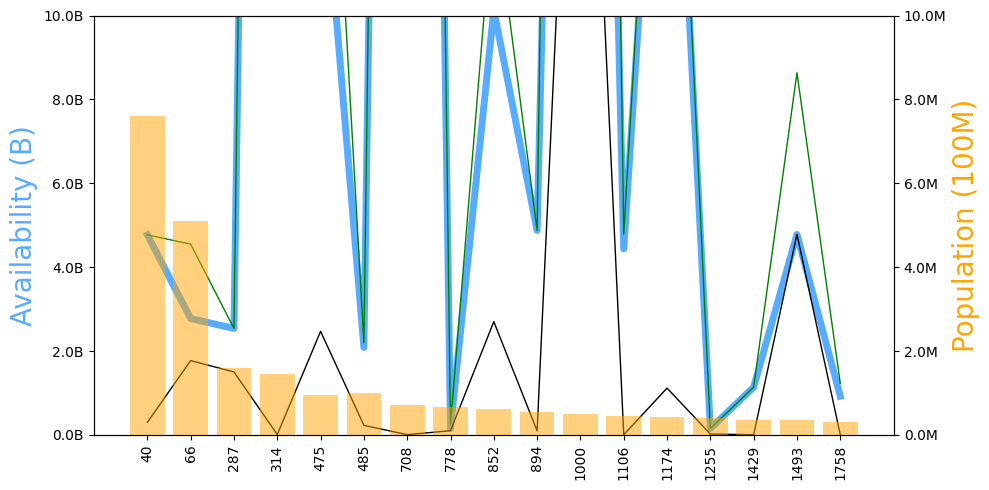

In [7]:
#############################################################
# it took 1min
#############################################################
bar_line(uid_str, riv_num)

In [8]:
def grid_to_latlon(row, col, extent):
    delta = 360/4320
    x_left, y_top = extent[0], extent[3]
    lon = x_left + (col+0.5) * delta
    lat = y_top - (row+0.5) * delta
    return lon, lat
    
def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3):
    projection = ccrs.PlateCarree()
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] != 0:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax

def toy():
    #
    msk_dir = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/vld_cty_'
    basin_cities_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/riv_num_/basin_to_cities_100km.json'
    with open(basin_cities_path, 'r') as json_file:
        new_basin_to_cities = json.load(json_file)
    #
    key_index = 64
    left = 70
    right = 85
    bottom = 10
    top = 25
    #
    resolution=12
    nx, ny = (right - left)*resolution, (top - bottom)*resolution
    rgnshape = (ny, nx)
    img_extent = (left, right, bottom, top)
    extent = (-180, 180, -90, 90)
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    
    ###########################################################################################
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

    # riv
    rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
    rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]
    rivnum_masked = np.ma.masked_where(rivnum_cropped != riv_num, rivnum_cropped)
    
    # discharge
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex] * 60 * 60 * 24 * 365 / 1000

    # lonlat
    lonlat_path = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat.npy'
    citylonlat = np.load(lonlat_path)

    nums = citylonlat[:, 0]
    lons = citylonlat[:, 1]
    lats = citylonlat[:, 2]

    # sort
    edges, riv_path_array, coords_a, city_list_removed = updown(new_basin_to_cities, uid_str=uid_str, riv_num=riv_num)
    sorted_order = topological_sort(edges)
    order = city_list_removed
    print(f'sorted_order: {sorted_order}')
    print(f'order: {order}')
    
    order_index = []
    for cnm in order:
        idx = np.where(np.array(nums) == cnm)[0]
        order_index.append(idx)
    print(f'order_index: {order_index}')

    target_lons = lons[order_index]
    target_lats = lats[order_index]
    
    # rivnxl
    path_dict = get_rivpath(riv_num, order, upperindex, lowerindex, leftindex, rightindex)

    # population
    updown_path = f'{h08dir}/wsi/dat/availablewater/updown_availability_100km_abandon_revised.txt'
    df_new = pd.read_csv(updown_path, delimiter='|', header=None)
    df_new.columns = df_new.iloc[0]
    df_new = df_new[1:].reset_index(drop=True)
    df_new = df_new.infer_objects()
    
    population = [df_new.loc[df_new['index'] == f'{city_num}', 'pop'].values[0] for city_num in order]
    population = [int(float(i)) for i in population]
    pop_size = [35 if i > 1e6 else 5 for i in population]

    mpcy_int = [df_new.loc[df_new['index'] == f'{city_num}', 'mpcy_int'].values[0] for city_num in order]
    target_mpcy = [int(float(i)) for i in mpcy_int]

    ###########################################################################################
    
    # cmap
    bounds = [0, 1000]
    cmap = mcolors.ListedColormap(['red', 'blue'])
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    rivnum_cmap = mcolors.ListedColormap(['#ffe500'])
    river_cmap = mcolors.ListedColormap(['#57acff'])

    # draw
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], projection)

    # rivnxl
    width = 1
    
    for city_num in order:
        path_coords = path_dict[city_num]
        
        #2つずつのペアに変換
        path_coords_lat = [coord[0] for coord in path_coords]
        path_coords_lon = [coord[1] for coord in path_coords]
        path_coords_pairs = list(zip(path_coords_lat, path_coords_lon))
        path_coords_grouped = [(path_coords_lat[i:i + 2], path_coords_lon[i:i + 2]) for i in range(len(path_coords) - 1)]
        
        for lat_coords, lon_coords in path_coords_grouped:
            # dischargeの取得
            discharge = rivout_cropped[lat_coords[0], lon_coords[0]]
            if discharge > 1e9:
                linewidth = 2.5
            else:
                linewidth = 0.5
            
            # lat_coordsとlon_coordsの変換
            lat_coords = [img_extent[3] - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
            lon_coords = [(lon + (1/(width * 2)))*(1/12) + img_extent[0] for lon in lon_coords]
            
            # ax.plotを使ってプロット
            ax.plot(lon_coords, lat_coords, 
                    markersize=0, linewidth=linewidth, color='#57acff',
                    marker='o', linestyle='-', transform=projection, zorder=1
                   )

    # rivnum
    bg = ax.imshow(rivnum_masked, 
                   alpha=0.5, cmap=rivnum_cmap, transform=projection, extent=img_extent, zorder=0
                  )

    # lonlat
    img = ax.scatter(target_lons, target_lats, c=target_mpcy, s=pop_size,
                     cmap=cmap, norm=norm, transform=projection, zorder=3
                    )

    # city outer
    for city_num in city_list_removed:
        ctymsk_path = f'{msk_dir}/city_{city_num:08}.gl5'
        citymask = np.fromfile(ctymsk_path, dtype='float32').reshape(2160, 4320)
        citymask_cropped = citymask[upperindex:lowerindex, leftindex:rightindex]
        draw_mask_sotowaku(img_extent, citymask_cropped, ax=ax, sotowaku_color='black', linewidth=1)

    # intake or prf location
    prf_latlon = [grid_to_latlon(coord[0][0], coord[1][0], extent) for coord, _ in coords_a]
    for lon, lat in prf_latlon:
        ax.plot(lon, lat, marker='^', color='green', markersize=5, transform=ccrs.PlateCarree(), zorder=2)

    # text
    texts = []
    for i, txt in enumerate(order_index):
        texts.append(ax.text(target_lons[i], target_lats[i], str(int(nums[txt])), fontsize=12, ha='right'))

    adjust_text(texts, only_move={'points': 'xy', 'text': 'xy'}, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))
    
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    ax.gridlines(visible=False)
    
    plt.show()

city_list: [40, 66, 287, 314, 475, 485, 708, 778, 852, 894, 940, 1000, 1106, 1174, 1255, 1429, 1478, 1493, 1758]
city_list_removed: [40, 66, 287, 314, 475, 485, 708, 778, 852, 894, 1000, 1106, 1174, 1255, 1429, 1493, 1758]
PRF only
largest_coord(array([872]), array([3100])), city_num: 40, uid_int: 64
INTAKE > prf
largest_coord(array([862]), array([3048])), city_num: 66, uid_int: 64
INTAKE only
largest_coord(array([851]), array([3049])), city_num: 287, uid_int: 64
INTAKE only
largest_coord(array([881]), array([3125])), city_num: 314, uid_int: 64
INTAKE > prf
largest_coord(array([867]), array([3065])), city_num: 475, uid_int: 64
INTAKE > prf
largest_coord(array([886]), array([3054])), city_num: 485, uid_int: 64
INTAKE only
largest_coord(array([880]), array([3123])), city_num: 708, uid_int: 64
INTAKE > prf
largest_coord(array([890]), array([3052])), city_num: 778, uid_int: 64
INTAKE > prf
largest_coord(array([876]), array([3053])), city_num: 852, uid_int: 64
PRF only
largest_coord(array([

/tmp/ipykernel_1138/2642495880.py:201: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  texts.append(ax.text(target_lons[i], target_lats[i], str(int(nums[txt])), fontsize=12, ha='right'))


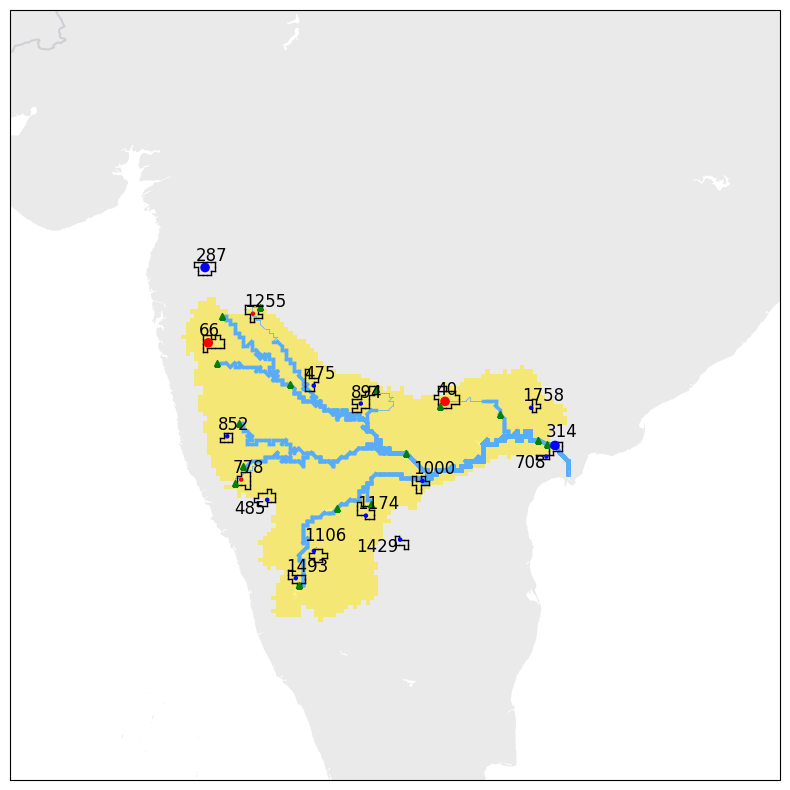

In [9]:
#############################################################
# scatterは都市の中心座標を表すのでprfやintakeとは無関係
# green: intakeまたはprfを指している．判別はしていない
# path_dict: 各都市に1つのrivpathしか描写していない
# it tooks 2min
#############################################################
toy()

In [10]:
from matplotlib.patches import FancyArrowPatch

def grid_to_latlon(row, col, extent):
    delta = 360/4320
    x_left, y_top = extent[0], extent[3]
    lon = x_left + (col+0.5) * delta
    lat = y_top - (row+0.5) * delta
    return lon, lat
    
def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3):
    projection = ccrs.PlateCarree()
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] != 0:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax

def toy2():
    #
    msk_dir = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/vld_cty_'
    basin_cities_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/riv_num_/basin_to_cities_100km.json'
    with open(basin_cities_path, 'r') as json_file:
        new_basin_to_cities = json.load(json_file)
    #
    key_index = 64
    left = 70
    right = 85
    bottom = 10
    top = 25
    #
    resolution=12
    nx, ny = (right - left)*resolution, (top - bottom)*resolution
    rgnshape = (ny, nx)
    img_extent = (left, right, bottom, top)
    extent = (-180, 180, -90, 90)
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    
    ###########################################################################################
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

    # riv
    rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
    rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]
    rivnum_masked = np.ma.masked_where(rivnum_cropped != riv_num, rivnum_cropped)
    
    # discharge
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex] * 60 * 60 * 24 * 365 / 1000

    # lonlat
    lonlat_path = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat.npy'
    citylonlat = np.load(lonlat_path)

    nums = citylonlat[:, 0]
    lons = citylonlat[:, 1]
    lats = citylonlat[:, 2]

    # sort
    edges, riv_path_array, coords_a, city_list_removed = updown(new_basin_to_cities, uid_str=uid_str, riv_num=riv_num)
    sorted_order = topological_sort(edges)
    order = city_list_removed
    print(f'sorted_order: {sorted_order}')
    print(f'order: {order}')
    
    order_index = []
    for cnm in order:
        idx = np.where(np.array(nums) == cnm)[0]
        order_index.append(idx)

    target_lons = lons[order_index]
    target_lats = lats[order_index]
    
    # rivnxl
    path_dict = get_rivpath_all(riv_num, order, upperindex, lowerindex, leftindex, rightindex)

    # population, mpcy
    updown_path = f'{h08dir}/wsi/dat/availablewater/updown_availability_100km_abandon_revised.txt'
    df_new = pd.read_csv(updown_path, delimiter='|', header=None)
    df_new.columns = df_new.iloc[0]
    df_new = df_new[1:].reset_index(drop=True)
    df_new = df_new.infer_objects()
    
    population = [df_new.loc[df_new['index'] == f'{city_num}', 'pop'].values[0] for city_num in order]
    population = [int(float(i)) for i in population]
    pop_size = [35 if i > 1e6 else 5 for i in population]

    mpcy_int = [df_new.loc[df_new['index'] == f'{city_num}', 'mpcy_int'].values[0] for city_num in order]
    target_mpcy = [int(float(i)) for i in mpcy_int]
    cityname_list = [df_new.loc[df_new['index'] == f'{city_num}', 'cityname'].values[0] for city_num in order]
    
    ###########################################################################################
    # if there are prf out of uid_int => add pprf_dct as list
    # if abandon prf => add prf to sprf_dct
    # if abandon int(no int) => add None to int_dct

    pprf_dct = {}
    sprf_dct = {}
    ibt_dct = {}

    sub_rivnum_list = []
    
    for city_num in order:
    
        # prf
        prf_dir = f'{h08dir}/global_city/dat/cty_prf_'
        prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
        prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
        prf_cropped = prf[upperindex:lowerindex, leftindex:rightindex]
    
        # int
        int_dir = f'{h08dir}/global_city/dat/cty_int_/{distance}km_samebasin'
        int_path = f'{int_dir}/city_{city_num:08}.gl5'
        intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
        intake_cropped = intake[upperindex:lowerindex, leftindex:rightindex]
        
        # 1. pprf: prf in uid
        # 2. sprf: prf not in uid
        # 3. pint: intake in uid
        # 4. sint: intake not in uid
        uid_int = int(riv_num)
        pprf_coord = np.where((prf_cropped == 1) & (rivnum_cropped == uid_int))
        sprf_coord = np.where((prf_cropped == 1) & (rivnum_cropped != uid_int))
        pint_coord = np.where((intake_cropped == 1) & (rivnum_cropped == uid_int))
        sint_coord = np.where((intake_cropped == 1) & (rivnum_cropped != uid_int))

        # secondary_rivnum
        sprf_rn = rivnum_cropped[sprf_coord]
        unq_sprf_rn = np.unique(sprf_rn)
        if unq_sprf_rn.size != 0:
            for i in unq_sprf_rn:
                sub_rivnum_list.append(i)
                
        sint_rn = rivnum_cropped[sint_coord]
        unq_sint_rn = np.unique(sint_rn)
        if unq_sint_rn.size != 0:
            for i in unq_sint_rn:
                sub_rivnum_list.append(i)
    
        # remove no sprf
        if sprf_coord[0].size == 0:
            sprf_coord = None
            
        # remove no sint
        if sint_coord[0].size == 0:
            sint_coord = None
    
        ##############################################################################
        # 1. int or pprf selection
        if pprf_coord[0].size != 0 and pint_coord[0].size != 0:
            prf_runout = rivout_cropped[pprf_coord][0] * 60 * 60 * 24 * 365 / (1000)
            int_runout = rivout_cropped[pint_coord][0] * 60 * 60 * 24 * 365 / (1000)

            # 1.1 pprf selected int abandon
            if prf_runout > int_runout:
                primary_coord = pprf_coord
                secondary_coord = sprf_coord
                #ibt_coord     = None #pint_coord
                ibt_coord     = pint_coord 
                
            # 1.2 inta selected pprf abandon
            else:
                if sprf_coord is None:
                    primary_coord = pprf_coord #ほんとはabandonしたいけどsprfがない場合
                    secondary_coord = sprf_coord
                else:
                    if len(sprf_coord[0]) == 1:
                        primary_coord = sprf_coord
                        secondary_coord = None
                    else:
                        primary_coord = (np.array([sprf_coord[0][0]]), np.array([sprf_coord[1][0]]))
                        secondary_coord = (np.delete(sprf_coord[0], 0), np.delete(sprf_coord[1], 0))
                    
                ibt_coord = pint_coord

        # 2. pprf only in rivnum
        elif pprf_coord[0].size != 0 and pint_coord[0].size == 0:
            primary_coord = pprf_coord
            secondary_coord = sprf_coord
            ibt_coord     = sint_coord

        # 3. int only in rivnum
        elif pprf_coord[0].size == 0 and pint_coord[0].size != 0:
            # 3.1 sprf
            if len(sprf_coord[0]) == 1:
                primary_coord = sprf_coord
                secondary_coord = None
            # 3.2 sprf of first index
            else:
                primary_coord = (np.array([sprf_coord[0][0]]), np.array([sprf_coord[1][0]]))
                secondary_coord = (np.delete(sprf_coord[0], 0), np.delete(sprf_coord[1], 0))
            ibt_coord = pint_coord
            
        else:
            primary_coord = None
            secondary_coord = None
            ibt_coord = None
        ##############################################################################
            
        pprf_dct[city_num] = primary_coord
        sprf_dct[city_num] = secondary_coord
        ibt_dct[city_num] = ibt_coord
    
    ###########################################################################################
    
    # cmap
    bounds = [0, 1000]
    cmap = mcolors.ListedColormap(['red', 'blue'])
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    rivnum_cmap = mcolors.ListedColormap(['#f2824c'])
    srivnum_cmap = mcolors.ListedColormap(['#fac74f'])
    river_cmap = mcolors.ListedColormap(['#57acff'])

    # draw
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], projection)

    # rivnxl
    width = 1
    for city_num in order:
        path_city_dict = path_dict[city_num]
        for key, path_coords in path_city_dict.items():
            
            #2つずつのペアに変換
            path_coords_lat = [coord[0] for coord in path_coords]
            path_coords_lon = [coord[1] for coord in path_coords]
            path_coords_pairs = list(zip(path_coords_lat, path_coords_lon))
            path_coords_grouped = [(path_coords_lat[i:i + 2], path_coords_lon[i:i + 2]) for i in range(len(path_coords) - 1)]
            
            for lat_coords, lon_coords in path_coords_grouped:
                # dischargeの取得
                discharge = rivout_cropped[lat_coords[0], lon_coords[0]]
                if discharge > 1e9:
                    linewidth = 3.5
                else:
                    linewidth = 1.5
                
                # lat_coordsとlon_coordsの変換
                lat_coords = [img_extent[3] - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
                lon_coords = [(lon + (1/(width * 2)))*(1/12) + img_extent[0] for lon in lon_coords]
                
                # ax.plotを使ってプロット
                ax.plot(lon_coords, lat_coords, 
                        markersize=0, linewidth=linewidth, color='#57acff',
                        marker='o', linestyle='-', transform=projection, zorder=1
                       )

    # rivnum
    bg = ax.imshow(rivnum_masked, 
                   alpha=0.5, cmap=rivnum_cmap, transform=projection, extent=img_extent
                  )

    for srn in sub_rivnum_list:
        srivnum_masked = np.ma.masked_where(rivnum_cropped != srn, rivnum_cropped)
        ax.imshow(srivnum_masked, 
                  alpha=0.5, cmap=srivnum_cmap, transform=projection, extent=img_extent
                  )

    # city outer
    for city_num in order:
        ctymsk_path = f'{msk_dir}/city_{city_num:08}.gl5'
        citymask = np.fromfile(ctymsk_path, dtype='float32').reshape(2160, 4320)
        citymask_cropped = citymask[upperindex:lowerindex, leftindex:rightindex]
        draw_mask_sotowaku(img_extent, citymask_cropped, ax=ax, sotowaku_color='white', linewidth=1.5)
        
    # prf
    pprf_latlon = [grid_to_latlon(coord[0][0], coord[1][0], img_extent) for _, coord in pprf_dct.items()]
    pprf_lon, pprf_lat = zip(*pprf_latlon)
    ax.scatter(pprf_lon, pprf_lat, c=target_mpcy, s=pop_size, 
            cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), zorder=3)
    
    # secondary prf
    sprf_latlon = [
        [grid_to_latlon(c[0], c[1], img_extent) for c in zip(coord[0], coord[1])] if coord is not None else [(None, None)] 
        for n, coord in sprf_dct.items()
    ]
    
    for coord_list in sprf_latlon:
        for lon, lat in coord_list:
            if lon is not None and lat is not None:
                ax.plot(lon, lat, marker='x', color='#c700fe', markersize=3, 
                        transform=ccrs.PlateCarree(), zorder=2)

    # int
    int_latlon = [
        grid_to_latlon(coord[0][0], coord[1][0], img_extent) if coord is not None else (None, None) 
        for n, coord in ibt_dct.items()
    ]
    for lon, lat in int_latlon:
        if lon is not None and lat is not None:
            ax.plot(lon, lat, marker='*', color='green', markersize=5, 
                    transform=ccrs.PlateCarree(), zorder=2)

    # arrow
    for int_latlon, prf_latlon in zip(int_latlon, pprf_latlon):
        if int_latlon[0] is not None and int_latlon[1] is not None:
            start_lon, start_lat = int_latlon[0], int_latlon[1]
            end_lon, end_lat = prf_latlon[0], prf_latlon[1]
            arrow = FancyArrowPatch((start_lon, start_lat), (end_lon, end_lat),
                                    color='green', linewidth=0.5, arrowstyle='-', mutation_scale=15, zorder=1)
            ax.add_patch(arrow)

    # city_name text
    texts = []
    for i, txt in enumerate(cityname_list):
        texts.append(ax.text(pprf_lon[i], pprf_lat[i], txt, fontsize=12, ha='left')) #left, center, right

    adjust_text(texts, only_move={'points': 'xy', 'text': 'xy'}, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

    # geography
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.3,edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    ax.gridlines(visible=False)
    
    plt.show()

city_list: [40, 66, 287, 314, 475, 485, 708, 778, 852, 894, 940, 1000, 1106, 1174, 1255, 1429, 1478, 1493, 1758]
city_list_removed: [40, 66, 287, 314, 475, 485, 708, 778, 852, 894, 1000, 1106, 1174, 1255, 1429, 1493, 1758]
PRF only
largest_coord(array([872]), array([3100])), city_num: 40, uid_int: 64
INTAKE > prf
largest_coord(array([862]), array([3048])), city_num: 66, uid_int: 64
INTAKE only
largest_coord(array([851]), array([3049])), city_num: 287, uid_int: 64
INTAKE only
largest_coord(array([881]), array([3125])), city_num: 314, uid_int: 64
INTAKE > prf
largest_coord(array([867]), array([3065])), city_num: 475, uid_int: 64
INTAKE > prf
largest_coord(array([886]), array([3054])), city_num: 485, uid_int: 64
INTAKE only
largest_coord(array([880]), array([3123])), city_num: 708, uid_int: 64
INTAKE > prf
largest_coord(array([890]), array([3052])), city_num: 778, uid_int: 64
INTAKE > prf
largest_coord(array([876]), array([3053])), city_num: 852, uid_int: 64
PRF only
largest_coord(array([

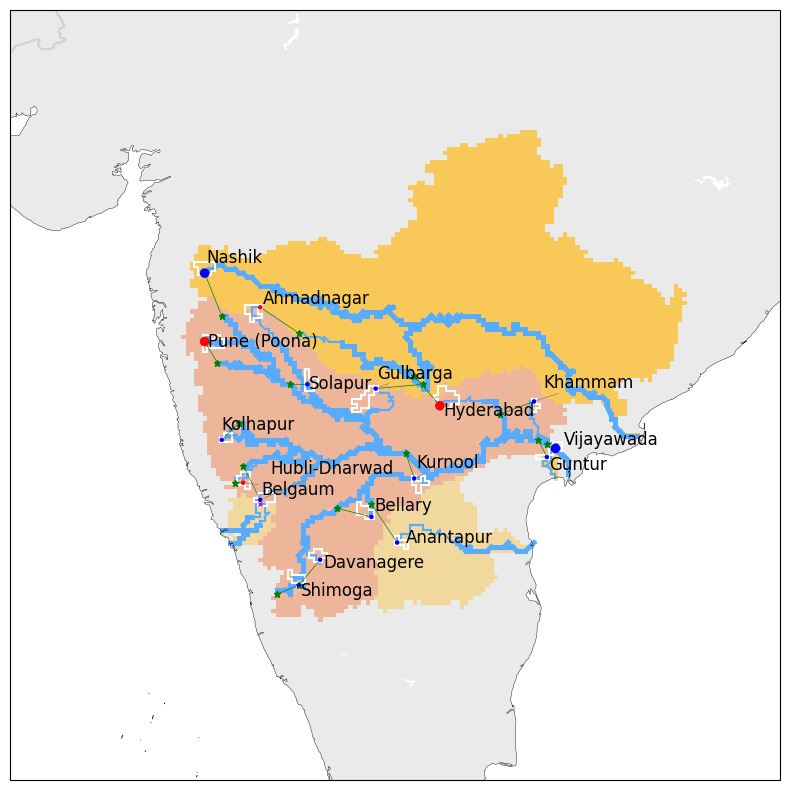

In [11]:
#############################################################
# scatter: pprf
# green: intake
# path_dict: 各都市のrivnum内外にあるprfとintakeのrivpathを描写
# 全領域をplotするから，もしcroppが狭いとエラーが発生する
#############################################################
# it tooks 3min
#############################################################
toy2()

In [12]:
from matplotlib.patches import FancyArrowPatch

def grid_to_latlon(row, col, extent):
    delta = 360/4320
    x_left, y_top = extent[0], extent[3]
    lon = x_left + (col+0.5) * delta
    lat = y_top - (row+0.5) * delta
    return lon, lat
    
def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3):
    projection = ccrs.PlateCarree()
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] != 0:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax

def test():
    #
    msk_dir = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/vld_cty_'
    basin_cities_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/riv_num_/basin_to_cities_100km.json'
    with open(basin_cities_path, 'r') as json_file:
        new_basin_to_cities = json.load(json_file)
    #
    key_index = 64
    left = 70
    right = 85
    bottom = 10
    top = 25
    #
    resolution=12
    nx, ny = (right - left)*resolution, (top - bottom)*resolution
    rgnshape = (ny, nx)
    img_extent = (left, right, bottom, top)
    extent = (-180, 180, -90, 90)
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    
    ###########################################################################################
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

    # riv
    rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
    rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]
    rivnum_masked = np.ma.masked_where(rivnum_cropped != riv_num, rivnum_cropped)
    
    # discharge
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex] * 60 * 60 * 24 * 365 / 1000

    # lonlat
    lonlat_path = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat.npy'
    citylonlat = np.load(lonlat_path)

    nums = citylonlat[:, 0]
    lons = citylonlat[:, 1]
    lats = citylonlat[:, 2]

    # sort
    edges, riv_path_array, coords_a, city_list_removed = updown(new_basin_to_cities, uid_str=uid_str, riv_num=riv_num)
    sorted_order = topological_sort(edges)
    order = city_list_removed
    print(f'sorted_order: {sorted_order}')
    print(f'order: {order}')
    
    order_index = []
    for cnm in order:
        idx = np.where(np.array(nums) == cnm)[0]
        order_index.append(idx)

    target_lons = lons[order_index]
    target_lats = lats[order_index]
    
    # rivnxl
    path_dict = get_rivpath_all(riv_num, order, upperindex, lowerindex, leftindex, rightindex)

    # population
    updown_path = f'{h08dir}/wsi/dat/availablewater/updown_availability_100km_abandon_revised.txt'
    df_new = pd.read_csv(updown_path, delimiter='|', header=None)
    df_new.columns = df_new.iloc[0]
    df_new = df_new[1:].reset_index(drop=True)
    df_new = df_new.infer_objects()
    
    population = [df_new.loc[df_new['index'] == f'{city_num}', 'pop'].values[0] for city_num in order]
    population = [int(float(i)) for i in population]
    pop_size = [35 if i > 1e6 else 5 for i in population]

    mpcy_int = [df_new.loc[df_new['index'] == f'{city_num}', 'mpcy_int'].values[0] for city_num in order]
    target_mpcy = [int(float(i)) for i in mpcy_int]
    cityname_list = [df_new.loc[df_new['index'] == f'{city_num}', 'cityname'].values[0] for city_num in order]
    
    ###########################################################################################
    # if there are prf out of uid_int => add pprf_dct as list
    # if abandon prf => add prf to sprf_dct
    # if abandon int(no int) => add None to int_dct

    pprf_dct = {}
    sprf_dct = {}
    ibt_dct = {}

    sub_rivnum_list = []
    
    for city_num in order:
    
        # prf
        prf_dir = f'{h08dir}/global_city/dat/cty_prf_'
        prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
        prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
        prf_cropped = prf[upperindex:lowerindex, leftindex:rightindex]
    
        # int
        int_dir = f'{h08dir}/global_city/dat/cty_int_/{distance}km_samebasin'
        int_path = f'{int_dir}/city_{city_num:08}.gl5'
        intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
        intake_cropped = intake[upperindex:lowerindex, leftindex:rightindex]
        
        # 1. pprf: prf in uid
        # 2. sprf: prf not in uid
        # 3. pint: intake in uid
        # 4. sint: intake not in uid
        uid_int = int(riv_num)
        pprf_coord = np.where((prf_cropped == 1) & (rivnum_cropped == uid_int))
        sprf_coord = np.where((prf_cropped == 1) & (rivnum_cropped != uid_int))
        pint_coord = np.where((intake_cropped == 1) & (rivnum_cropped == uid_int))
        sint_coord = np.where((intake_cropped == 1) & (rivnum_cropped != uid_int))
        
        # secondary_rivnum
        sprf_rn = rivnum_cropped[sprf_coord]
        unq_sprf_rn = np.unique(sprf_rn)
        if unq_sprf_rn.size != 0:
            for i in unq_sprf_rn:
                sub_rivnum_list.append(i)
                
        sint_rn = rivnum_cropped[sint_coord]
        unq_sint_rn = np.unique(sint_rn)
        if unq_sint_rn.size != 0:
            for i in unq_sint_rn:
                sub_rivnum_list.append(i)

        # remove no sprf
        if sprf_coord[0].size == 0:
            sprf_coord = None
            
        # remove no sint
        if sint_coord[0].size == 0:
            sint_coord = None
    
        ##############################################################################
        # 1. int or pprf selection
        if pprf_coord[0].size != 0 and pint_coord[0].size != 0:
            prf_runout = rivout_cropped[pprf_coord][0] * 60 * 60 * 24 * 365 / (1000)
            int_runout = rivout_cropped[pint_coord][0] * 60 * 60 * 24 * 365 / (1000)

            # 1.1 pprf selected int abandon
            if prf_runout > int_runout:
                primary_coord = pprf_coord
                secondary_coord = sprf_coord
                ibt_coord     = None #pint_coord
                
            # 1.2 inta selected pprf abandon
            else:
                if sprf_coord is None:
                    primary_coord = pprf_coord #ほんとはabandonしたいけどsprfがない場合
                    secondary_coord = sprf_coord
                else:
                    if len(sprf_coord[0]) == 1:
                        primary_coord = sprf_coord
                        secondary_coord = None
                    else:
                        primary_coord = (np.array([sprf_coord[0][0]]), np.array([sprf_coord[1][0]]))
                        secondary_coord = (np.delete(sprf_coord[0], 0), np.delete(sprf_coord[1], 0))
                    
                ibt_coord = pint_coord

        # 2. pprf only in rivnum
        elif pprf_coord[0].size != 0 and pint_coord[0].size == 0:
            primary_coord = pprf_coord
            secondary_coord = sprf_coord
            ibt_coord     = sint_coord

        # 3. int only in rivnum
        elif pprf_coord[0].size == 0 and pint_coord[0].size != 0:
            # 3.1 sprf
            if len(sprf_coord[0]) == 1:
                primary_coord = sprf_coord
                secondary_coord = None
            # 3.2 sprf of first index
            else:
                primary_coord = (np.array([sprf_coord[0][0]]), np.array([sprf_coord[1][0]]))
                secondary_coord = (np.delete(sprf_coord[0], 0), np.delete(sprf_coord[1], 0))
            ibt_coord = pint_coord
            
        else:
            primary_coord = None
            secondary_coord = None
            ibt_coord = None
            
        ##############################################################################
            
        pprf_dct[city_num] = primary_coord
        sprf_dct[city_num] = secondary_coord
        ibt_dct[city_num] = ibt_coord
    
    ###########################################################################################
    
    # cmap
    bounds = [0, 1000]
    cmap = mcolors.ListedColormap(['red', 'blue'])
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    rivnum_cmap = mcolors.ListedColormap(['#f2824c'])
    srivnum_cmap = mcolors.ListedColormap(['#fac74f'])
    river_cmap = mcolors.ListedColormap(['#57acff'])

    # draw
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], projection)

    # rivnxl
    width = 1
    for city_num in order:
        path_city_dict = path_dict[city_num]
        
        for key, path_coords in path_city_dict.items():
            
            #2つずつのペアに変換
            path_coords_lat = [coord[0] for coord in path_coords]
            path_coords_lon = [coord[1] for coord in path_coords]
            path_coords_pairs = list(zip(path_coords_lat, path_coords_lon))
            path_coords_grouped = [(path_coords_lat[i:i + 2], path_coords_lon[i:i + 2]) for i in range(len(path_coords) - 1)]
            
            for lat_coords, lon_coords in path_coords_grouped:
                # dischargeの取得
                discharge = rivout_cropped[lat_coords[0], lon_coords[0]]
                if discharge > 1e9:
                    linewidth = 2.0
                else:
                    linewidth = 0.5
                
                # lat_coordsとlon_coordsの変換
                lat_coords = [img_extent[3] - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
                lon_coords = [(lon + (1/(width * 2)))*(1/12) + img_extent[0] for lon in lon_coords]
                
                # ax.plotを使ってプロット
                ax.plot(lon_coords, lat_coords, 
                        markersize=0, linewidth=linewidth, color='#57acff',
                        marker='o', linestyle='-', transform=projection, zorder=1
                       )

    # rivnum
    bg = ax.imshow(rivnum_masked, 
                   alpha=0.5, cmap=rivnum_cmap, transform=projection, extent=img_extent
                  )

    for srn in sub_rivnum_list:
        srivnum_masked = np.ma.masked_where(rivnum_cropped != srn, rivnum_cropped)
        ax.imshow(srivnum_masked, 
                  alpha=0.5, cmap=srivnum_cmap, transform=projection, extent=img_extent
                  )

    # city outer
    for city_num in order:
        ctymsk_path = f'{msk_dir}/city_{city_num:08}.gl5'
        citymask = np.fromfile(ctymsk_path, dtype='float32').reshape(2160, 4320)
        citymask_cropped = citymask[upperindex:lowerindex, leftindex:rightindex]
        draw_mask_sotowaku(img_extent, citymask_cropped, ax=ax, sotowaku_color='white', linewidth=1.5)
        
    # prf
    pprf_latlon = [grid_to_latlon(coord[0][0], coord[1][0], img_extent) for _, coord in pprf_dct.items()]
    pprf_lon, pprf_lat = zip(*pprf_latlon)
    ax.scatter(pprf_lon, pprf_lat, c=target_mpcy, s=pop_size, 
            cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), zorder=3)

    # int
    int_latlon = [
        grid_to_latlon(coord[0][0], coord[1][0], img_extent) if coord is not None else (None, None) 
        for n, coord in ibt_dct.items()
    ]
    for lon, lat in int_latlon:
        if lon is not None and lat is not None:
            ax.plot(lon, lat, marker='*', color='green', markersize=5, 
                    transform=ccrs.PlateCarree(), zorder=2)

    # arrow
    for int_latlon, prf_latlon in zip(int_latlon, pprf_latlon):
        if int_latlon[0] is not None and int_latlon[1] is not None:
            start_lon, start_lat = int_latlon[0], int_latlon[1]
            end_lon, end_lat = prf_latlon[0], prf_latlon[1]
            arrow = FancyArrowPatch((start_lon, start_lat), (end_lon, end_lat),
                                    color='green', linewidth=0.5, arrowstyle='-', mutation_scale=15, zorder=1)
            ax.add_patch(arrow)

    # secondary prf
    sprf_latlon = [
        [grid_to_latlon(c[0], c[1], img_extent) for c in zip(coord[0], coord[1])] if coord is not None else [(None, None)] 
        for n, coord in sprf_dct.items()
    ]
    
    for coord_list in sprf_latlon:
        for lon, lat in coord_list:
            if lon is not None and lat is not None:
                ax.plot(lon, lat, marker='x', color='#c700fe', markersize=3, 
                        transform=ccrs.PlateCarree(), zorder=2)

    # text
    texts = []
    for i, txt in enumerate(cityname_list):
        texts.append(ax.text(pprf_lon[i], pprf_lat[i], txt, fontsize=12, ha='left')) #left, center, right

    adjust_text(texts, only_move={'points': 'xy', 'text': 'xy'}, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))
    
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.3,edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    ax.gridlines(visible=False)

    ax.set_xlim(70, 85)
    ax.set_ylim(10, 25)
    
    plt.show()

city_list: [40, 66, 287, 314, 475, 485, 708, 778, 852, 894, 940, 1000, 1106, 1174, 1255, 1429, 1478, 1493, 1758]
city_list_removed: [40, 66, 287, 314, 475, 485, 708, 778, 852, 894, 1000, 1106, 1174, 1255, 1429, 1493, 1758]
PRF only
largest_coord(array([872]), array([3100])), city_num: 40, uid_int: 64
INTAKE > prf
largest_coord(array([862]), array([3048])), city_num: 66, uid_int: 64
INTAKE only
largest_coord(array([851]), array([3049])), city_num: 287, uid_int: 64
INTAKE only
largest_coord(array([881]), array([3125])), city_num: 314, uid_int: 64
INTAKE > prf
largest_coord(array([867]), array([3065])), city_num: 475, uid_int: 64
INTAKE > prf
largest_coord(array([886]), array([3054])), city_num: 485, uid_int: 64
INTAKE only
largest_coord(array([880]), array([3123])), city_num: 708, uid_int: 64
INTAKE > prf
largest_coord(array([890]), array([3052])), city_num: 778, uid_int: 64
INTAKE > prf
largest_coord(array([876]), array([3053])), city_num: 852, uid_int: 64
PRF only
largest_coord(array([

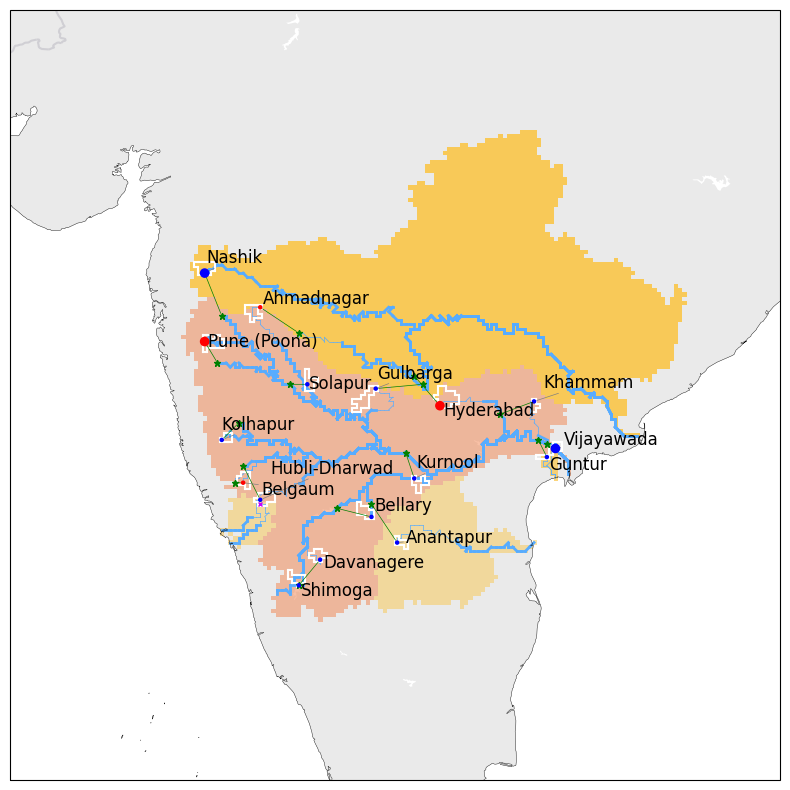

In [13]:
#############################################################
# toy2と同じ．違いは: set_xlim, set_ylimで表示表域を狭くしている
# scatter: pprf
# green: intake
# path_dict: 各都市のrivnum内外にあるprfとintakeのrivpathを描写
#############################################################
#############################################################
# it tooks 3min
#
#key_index = 64
#left = 70
#right = 85
#bottom = 10
#top = 25
#############################################################
test()

In [15]:
def check(city_num):
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'

    # new
    updown_path = f'{h08dir}/wsi/dat/availablewater/updown_availability_100km_abandon.txt'
    df_new = pd.read_csv(updown_path, delimiter='|', header=None)
    df_new.columns = df_new.iloc[0]
    df_new = df_new[1:].reset_index(drop=True)
    df_new = df_new.infer_objects()
    df_filtered = df_new[df_new['index'] == f'{city_num}']
    display(df_filtered.head())

    # org
    updown_path_org = f'{h08dir}/wsi/dat/availablewater/updown_availability.txt'
    df_org = pd.read_csv(updown_path_org, delimiter='|', header=None)
    df_org.columns = df_org.iloc[0]
    df_org = df_org[1:].reset_index(drop=True)
    df_org = df_org.infer_objects()
    df_filtered_org = df_org[df_org['index'] == f'{city_num}']
    display(df_filtered_org.head())
    
    # rivout
    rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivnum_gl5 = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320)
    rivout_gl5 = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)

    # prf
    prf_dir = f'{h08dir}/global_city/dat/cty_prf_'
    prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
    prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
    print(f'-------------------------------------------------------------------')

    # int
    int_dir = f'{h08dir}/global_city/dat/cty_int_/{distance}km_samebasin'
    int_path = f'{int_dir}/city_{city_num:08}.gl5'
    intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)

    # overlap
    overlap_path = f'{h08dir}/global_city/dat/cty_lst_/gpw4/overlap_hidden_only.txt'
    with open(overlap_path, 'r') as f:
        numbers = [int(line.strip()) for line in f]
    if city_num in numbers:
        print(f'{city_num} is overlappled city')
    if not os.path.exists(prf_path):
        print(f'{city_num} is invalid prf')

    # check if intake exists
    int_rivnum_list = rivnum_gl5[intake==1]

    if int_rivnum_list.size != 0:
        
        int_rivnum = rivnum_gl5[intake==1][0]
        flag, largest, all_int, prf_copy = prf_int_flag(prf, intake, int_rivnum, rivnum_gl5, rivout_gl5)
        print(f'city_num: {city_num}, flag: {flag}')
        print(f'-------------------------------------------------------------------')
    
        dis_prf = np.sum(rivout_gl5[(prf==1) & (rivnum_gl5!=int_rivnum)])* 60 * 60 * 24 * 365 / (1000) # m3/year
        ind_prf_coord = np.where((prf == 1) & (rivnum_gl5 != int_rivnum))
        print(f'individual_prf_coord: {ind_prf_coord}')
        print(f'individual_prf_ava: {dis_prf/1e9}')
        print(f'-------------------------------------------------------------------')
        
        els_prf = np.sum(rivout_gl5[(prf==1) & (rivnum_gl5==int_rivnum)])* 60 * 60 * 24 * 365 / (1000) # m3/year
        prf_samerivnum_coord = np.where((prf == 1) & (rivnum_gl5 == int_rivnum))
        print(f'prf_samerivnum_coord: {prf_samerivnum_coord}')
        print(f'prf_samerivnum_ava: {els_prf/1e9}')
        print(f'-------------------------------------------------------------------')
        
        dis_int = np.sum(rivout_gl5[intake==1])*60*60*24*365/1000 # m3/year
        intake_coord = np.where((intake==1) & (rivnum_gl5 == int_rivnum))
        print(f'intake_coord: {intake_coord}')
        print(f'intake_ava: {dis_int/1e9}')
        print(f'-------------------------------------------------------------------')
        
    else:
        dis_prf = np.sum(rivout_gl5[prf==1])* 60 * 60 * 24 * 365 / (1000) # m3/year
        ind_prf_coord = np.where(prf == 1)
        print('no-intake-point')
        print(f'individual_prf_coord: {ind_prf_coord}')
        print(f'individual_prf_ava: {dis_prf/1e9}')
        print(f'-------------------------------------------------------------------')
        
        dis_int = np.sum(rivout_gl5[intake==1])*60*60*24*365/1000 # m3/year
        intake_coord = np.where(intake==1)
        print('no-intake-point')
        print(f'intake_coord: {intake_coord}')
        print(f'intake_ava: {dis_int/1e9}')
        print(f'-------------------------------------------------------------------')
    
check(91)

,index,flag,rate,wup,pop,ava,mpcy,potential,region,country,cityname,12region,ava_int,mpcy_int
90,91,False,1.0070956863302474,3869.675,3897133.0,9210716806.691164,2363.4597040160456,12.0,eastern africa,United Republic of Tanzania,Dar es Salaam,Southern Africa,9210716806.691164,2363.4597040160456


,index,flag,rate,wup,pop,ava,mpcy,potential,region,country,cityname,12region
90,91,False,1.0070956863302474,3869.675,3897133.0,289158326.71875,74.1977055232013,12.0,eastern africa,United Republic of Tanzania,Dar es Salaam,Southern Africa


-------------------------------------------------------------------
INTAKE only
city_num: 91, flag: intake-only
-------------------------------------------------------------------
individual_prf_coord: (array([1163]), array([2630]))
individual_prf_ava: 0.28915832671875
-------------------------------------------------------------------
prf_samerivnum_coord: (array([], dtype=int64), array([], dtype=int64))
prf_samerivnum_ava: 0.0
-------------------------------------------------------------------
intake_coord: (array([1155]), array([2623]))
intake_ava: 9.208831302
-------------------------------------------------------------------
